In [ ]:
import h5py
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import tensorflow as tf
import numpy as np
import math
import csv
import time
from tensorflow.keras import layers, models, Model, Input, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as mpimg
from scipy.optimize import curve_fit
from scipy.stats import norm
from matplotlib.gridspec import GridSpec

Definiowanie nazw używanych plików

In [58]:
hdf5_file = "energy_data.h5"
test_hdf5_file = "angle_data.h5"
klasyka_file='klasyka_z_regresja.csv'
klasyka_file2='TE_RMSE_sigma.txt'

Zdefiniuj jak dużą część układu chcesz (p) i globalne współczynniki poprawiania regresji (class_coeff=[współczynnik liniowy, wyraz wolny])

In [59]:
p=1
class_coeff=[1.149,1.13]
Energies=np.sort(np.array([130,140,40,30,200,100,90,170,120,150,190,70,160,60,80,180,110,50,25,75,125]))

In [60]:
with open(klasyka_file) as csv_file:
    csv_read=csv.reader(csv_file, delimiter=',')
    reg=list(csv_read)
kTE=[]
kMAE=[]
for i in range(1,len(reg)):
    kTE.append(float(reg[i][0][0:5]))
    if reg[i][0][10]=='\t':
        kMAE.append(float(reg[i][0][11:16]))
    else:
        kMAE.append(float(reg[i][0][10:16]))
kTE=np.array(kTE)
kMAE=np.array(kMAE)
with open(klasyka_file2) as csv_file:
    csv_read=csv.reader(csv_file, delimiter=',')
    reg=list(csv_read)
kRMS=[]
kSTD=[]
for i in range(1,len(reg)):
    if reg[i][0][10]=='\t':
        kRMS.append(float(reg[i][0][11:16]))
    else:
        kRMS.append(float(reg[i][0][10:16]))
    kSTD.append(float(reg[i][0][-8:-1]))
kRMS=np.array(kRMS)
kSTD=np.array(kSTD)

Przygotowanie danych

In [61]:
# Define the generator function
def hdf5_generator(hdf5_file):
    with h5py.File(hdf5_file, 'r') as f:
        data = f['data']  # Assuming data is (x, y, z) for each sample in the file
        labels = f['labels']
        num_samples = data.shape[0]  # The number of samples in the dataset

        for i in range(num_samples):
            image = data[i]  # Shape of image: (x, y, z)
            label = labels[i]  # Shape of label, depending on your task

            # Add color channel dimension to the image (shape becomes (x, y, z, 1))
            image = np.expand_dims(image, axis=-1)  # Adding the color channel (1 for grayscale)
            
            # Yield the image and label
            yield image, label

# Define the dataset pipeline
dataset = tf.data.Dataset.from_generator(
    hdf5_generator,
    args=[hdf5_file],  # Provide the path to your HDF5 file here
    output_signature=(
        tf.TensorSpec(shape=(20, 110, 11, 1), dtype=tf.float32),  # Shape with added color channel
        tf.TensorSpec(shape=(), dtype=tf.int16)  # Label shape
    )
)


print("Train data loaded")

def test_hdf5_generator(hdf5_file):
    with h5py.File(test_hdf5_file, 'r') as f:
        data = f['data']  # Assuming data is (x, y, z) for each sample in the file
        labels = f['labels']
        num_samples = data.shape[0]  # The number of samples in the dataset

        for i in range(num_samples):
            image = data[i]  # Shape of image: (x, y, z)
            label = labels[i]  # Shape of label, depending on your task

            # Add color channel dimension to the image (shape becomes (x, y, z, 1))
            image = np.expand_dims(image, axis=-1)  # Adding the color channel (1 for grayscale)
            
            # Yield the image and label
            yield image, label

# Define the dataset pipeline
test_dataset = tf.data.Dataset.from_generator(
    test_hdf5_generator,
    args=[test_hdf5_file],  # Provide the path to your HDF5 file here
    output_signature=(
        tf.TensorSpec(shape=(20, 110, 11, 1), dtype=tf.float32),  # Shape with added color channel
        tf.TensorSpec(shape=(), dtype=tf.int16)  # Label shape
    )
)
print("Validation and test data loaded")
with h5py.File(hdf5_file, "r") as hdf:
    dataset_size = len(hdf["data"])  # Or hdf["labels"], if they have the same length
    print(f"Dataset size: {dataset_size}")
train_dataset=dataset.take(int(0.8*dataset_size*p))
train_dataset=train_dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_dataset=test_dataset.take(int(int(0.3*dataset_size*p)))
val_dataset=val_dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds=test_dataset.skip(int(int(0.3*dataset_size*p))).take(int(int(0.1*dataset_size*p)))
test_ds=test_ds.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_ds2=dataset.skip(int(0.8*dataset_size*p)).take(int(0.2*dataset_size*p))
test_ds2=test_ds2.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
print("Dane treningowe, walidacyjne i testowe ready")

Train data loaded
Validation and test data loaded
Dataset size: 450000
Dane treningowe, walidacyjne i testowe ready


Definiujemy sobie EarlyStopping

In [62]:
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=3,                 # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True   # Restore model weights from the best epoch
)

class ValLossForE(tf.keras.metrics.Metric):
    def __init__(self, E=5, name=None, **kwargs):
        # Dynamically set the metric name
        formatted_name = f"loss_for_{0.1 * E}_GeV"
        super().__init__(name=formatted_name, **kwargs)
        
        self.E = E  # The specific value to filter
        self.total_loss = self.add_weight(name="total_loss", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        mask = tf.equal(y_true, self.E)  # Filter only y_true == E

        selected_y_true = tf.boolean_mask(y_true, mask)
        selected_y_pred = tf.boolean_mask(y_pred, mask)

        if tf.size(selected_y_true) > 0:  # Avoid empty tensors
            loss = tf.keras.losses.mean_squared_error(selected_y_true, selected_y_pred)
            self.total_loss.assign_add(tf.reduce_sum(loss))
            self.count.assign_add(tf.cast(tf.size(loss), tf.float32))

    def result(self):
        return tf.math.divide_no_nan(self.total_loss, self.count)  # Avoid division by zero




Tu definiujemy sobie nasz model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 3D_Input (InputLayer)          [(None, 20, 110, 11  0           []                               
                                , 1)]                                                             
                                                                                                  
 conv3d_5 (Conv3D)              (None, 20, 110, 11,  896         ['3D_Input[0][0]']               
                                 32)                                                              
                                                                                                  
 max_pooling3d_5 (MaxPooling3D)  (None, 10, 55, 5, 3  0          ['conv3d_5[0][0]']               
                                2)                                                          

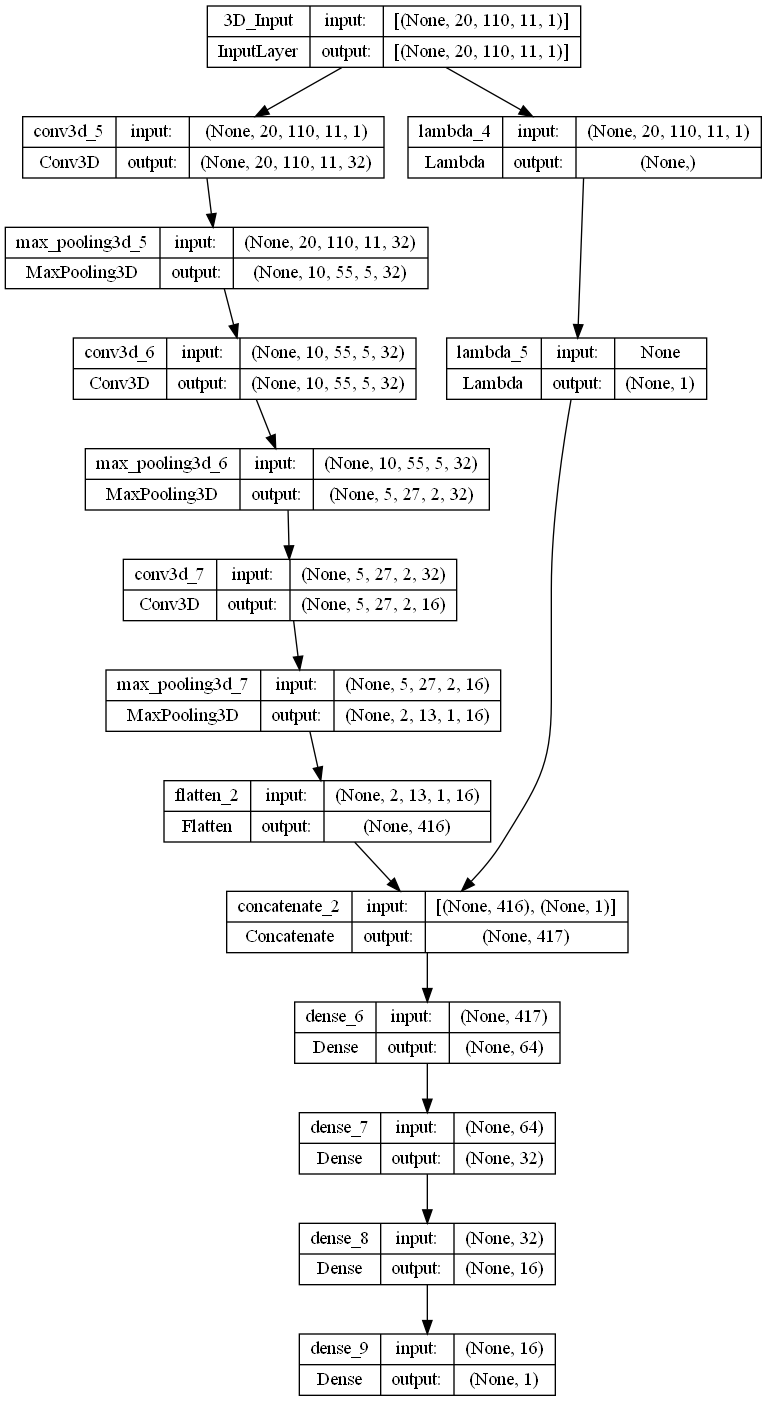

In [63]:
#Tu zdefiniuj model
input_3d = Input(shape=(20, 110, 11, 1), name='3D_Input')

# 3D CNN Path
x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(input_3d)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

x = layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

x = layers.Conv3D(16, kernel_size=(3, 3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

# Flatten 3D features
x = layers.Flatten()(x)

summed_tensor = Lambda(lambda t: tf.reduce_sum(t, axis=[1, 2, 3, 4]))(input_3d)  # Sum over spatial dimensions
summed_tensor_expanded = Lambda(lambda t: tf.expand_dims(t, axis=-1))(summed_tensor)  # Expand to (None, 1)
summed_tensor_exp =(summed_tensor_expanded/10-class_coeff[1])/class_coeff[0]
# Ensure shapes are compatible for concatenation
combined = layers.Concatenate(axis=-1)([x, summed_tensor_expanded])  # Concatenate along last axis


# Fully Connected Layers
fc = layers.Dense(64, activation='relu')(combined)
fc = layers.Dense(32, activation='relu')(fc)
fc = layers.Dense(16, activation='relu')(fc)


# Output Layer
output = layers.Dense(1, activation='linear')(fc)

# Define the Model
model = Model(inputs=[input_3d], outputs=output)

# Compile the Model
metrics=[]
for E in Energies:
    metrics.append(ValLossForE(E=E))
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=metrics) 
model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Trening i obróbka wyników

In [64]:
csv_logger = tf.keras.callbacks.CSVLogger("training_log5.csv", append=True)

with tf.device('/GPU:0'):
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        shuffle=True,
        epochs=20,                 # Set a high number of epochs; EarlyStopping will stop early
        callbacks=[early_stopping, csv_logger],  # Add EarlyStopping to callbacks
        verbose=1
    )
print("Wytrenowane!")

#Generowanie danych
y_pred=model.predict(test_ds).flatten()
y_true = np.array([label.numpy() for _, label in test_ds]).flatten()
y_pred2=model.predict(test_ds2).flatten()
y_true2 = np.array([label.numpy() for _, label in test_ds2]).flatten()
y_true=np.concatenate((y_true,y_true2),axis=0)
y_pred=np.concatenate((y_pred,y_pred2),axis=0)

Epoch 1/20
11250/11250 [==============================] - 737s 65ms/step - loss: 48.9230 - loss_for_2.5_GeV: 0.0000e+00 - loss_for_3.0_GeV: 10.8529 - loss_for_4.0_GeV: 13.9358 - loss_for_5.0_GeV: 18.2746 - loss_for_6.0_GeV: 22.1960 - loss_for_7.0_GeV: 26.0266 - loss_for_7.5_GeV: 0.0000e+00 - loss_for_8.0_GeV: 30.6811 - loss_for_9.0_GeV: 35.5212 - loss_for_10.0_GeV: 39.6260 - loss_for_11.0_GeV: 45.5295 - loss_for_12.0_GeV: 48.9005 - loss_for_12.5_GeV: 0.0000e+00 - loss_for_13.0_GeV: 51.8416 - loss_for_14.0_GeV: 57.3448 - loss_for_15.0_GeV: 64.2900 - loss_for_16.0_GeV: 71.0811 - loss_for_17.0_GeV: 71.6754 - loss_for_18.0_GeV: 82.5299 - loss_for_19.0_GeV: 84.7663 - loss_for_20.0_GeV: 98.6366 - val_loss: 29.3103 - val_loss_for_2.5_GeV: 10.3827 - val_loss_for_3.0_GeV: 0.0000e+00 - val_loss_for_4.0_GeV: 0.0000e+00 - val_loss_for_5.0_GeV: 15.4458 - val_loss_for_6.0_GeV: 0.0000e+00 - val_loss_for_7.0_GeV: 0.0000e+00 - val_loss_for_7.5_GeV: 24.5843 - val_loss_for_8.0_GeV: 0.0000e+00 - val_loss_

Jeśli chcesz zapisać model to uruchom poniższą komórkę

In [ ]:
model.save('tytuł.h5')

Teraz generujemy grafiki

In [94]:
def gaussian(x, mu, sigma, amplitude):
    return amplitude * norm.pdf(x, mu, sigma)

def fit_gaussian_to_histogram(dEnergy, E, n_bins=30):
    # Construct the histogram
    hist, bin_edges = np.histogram(dEnergy, bins=n_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Initial guess for the fitting parameters
    initial_sigma = np.std(dEnergy)
    initial_amplitude = np.max(hist)

    # Fix the mean to E
    mu_fixed = E
    # Fit the Gaussian function to the histogram data
    # Only fit sigma and amplitude, keep mu fixed
    popt, pcov = curve_fit(
        lambda x, sigma, amplitude: gaussian(x, mu_fixed, sigma, amplitude),
        bin_centers, hist, p0=[initial_sigma, initial_amplitude]
    )
    # Extract the fitted parameters
    sigma_fit, amplitude_fit = popt

    # Calculate the goodness of fit (R-squared)
    ss_res = np.sum((hist - gaussian(bin_centers, mu_fixed, sigma_fit, amplitude_fit))**2)
    ss_tot = np.sum((hist - np.mean(hist))**2)
    r_squared = 1 - (ss_res / ss_tot)

    return mu_fixed, sigma_fit, r_squared

def Gaussowisko(E_pred, E_true, Energies,n_bins):
    sigmas=[]
    fig, axs = plt.subplots(math.ceil(len(Energies)/3), 3, figsize=(15, 5 * math.ceil(len(Energies)/3)))
    axs = axs.flatten()
    for i in range(0,len(Energies)):
        E=Energies[i]
        mu, sigma, r_squared = fit_gaussian_to_histogram(E_pred[E_true==E], E)
        axs[i].hist(E_pred[E_true==E], bins=n_bins, density=True, alpha=0.6, color='g', label='Histogram')
        xmin, xmax = axs[i].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, sigma)
        axs[i].plot(x, p, 'k', linewidth=2, label='Gaussian Fit')
        axs[i].text(0.05, 0.95, f'$\mu$ = {mu:.2f}\n$\sigma$ = {sigma:.2f}\nE = {E}\n$R^2$ = {r_squared:.2f}',transform=axs[i].transAxes, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.5))
        axs[i].set_title(f'Histogram and Gaussian Fit for E = {E}')
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Density')
        axs[i].legend()
        axs[i].grid(True)
        sigmas.append(sigma)
    plt.tight_layout()
    plt.show()
    plt.close()
    return np.array(sigmas)

def Metrics(E_true,E_pred,Energies):
    RMS=np.zeros((len(Energies)))
    ME=np.zeros((len(Energies)))
    MAE=np.zeros((len(Energies)))
    for i in range(0,len(Energies)):
        RMS[i]=np.sqrt(np.mean((E_true[E_true==Energies[i]]-E_pred[E_true==Energies[i]])**2))
        ME[i]=np.mean(E_pred[E_true==Energies[i]]-E_true[E_true==Energies[i]])
        MAE[i]=np.mean(np.abs(E_pred[E_true==Energies[i]]-E_true[E_true==Energies[i]]))
    return RMS, ME, MAE, MAE/np.sqrt(Energies)

def generate_subplots(Energies, ME, kMAE, MAE, knormMAE, normMAE, kRMS, RMS, kSTD, STD, TE):
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))

    # First row
    axes[0, 0].scatter(Energies, ME, label='model', marker='o', color='black')
    axes[0, 0].set_xlabel('Energies')
    axes[0, 0].set_ylabel('Error')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].scatter(TE, kMAE, label='klasyka', marker='x', color='gray')
    axes[0, 1].scatter(Energies, MAE, label='model', marker='o', color='black')
    axes[0, 1].set_xlabel('Energies')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Second row
    axes[1, 0].scatter(TE, knormMAE, label='klasyka', marker='x', color='gray')
    axes[1, 0].scatter(Energies, normMAE, label='model', marker='o', color='black')
    axes[1, 0].set_xlabel('Energies')
    axes[1, 0].set_ylabel('Normalized Error')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    ratio=[]
    for E in TE:
        ratio.append(MAE[Energies==E]/kMAE[TE==E])

    axes[1, 1].scatter(TE, ratio, label='Ratio model/klasyka', marker='o', color='black')
    axes[1, 1].set_xlabel('Energies')
    axes[1, 1].set_ylabel('Ratio')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    # Third row
    axes[2, 0].scatter(TE, kRMS, label='klasyka', marker='x', color='gray')
    axes[2, 0].scatter(Energies, RMS, label='model', marker='o', color='black')
    axes[2, 0].set_xlabel('Energies')
    axes[2, 0].set_ylabel('RMS')
    axes[2, 0].legend()
    axes[2, 0].grid(True)

    axes[2, 1].scatter(TE, kSTD, label='klasyka', marker='x', color='gray')
    axes[2, 1].scatter(Energies, STD, label='model', marker='o', color='black')
    axes[2, 1].set_xlabel('Energies')
    axes[2, 1].set_ylabel('STD')
    axes[2, 1].legend()
    axes[2, 1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_training_data(Energies, path_to_training_logs, path_to_image):
    # Create a list to store the values for each energy category
    energy_values = [[] for _ in range(len(Energies))]
    val_energy_values = [[] for _ in range(len(Energies))]

    # Open the CSV file
    with open(path_to_training_logs, mode='r') as file:
        csv_reader = csv.DictReader(file)

        # Iterate over each row in the CSV file
        for row in csv_reader:
            # Iterate over each energy value and extract the corresponding column
            for i, energy in enumerate(Energies):
                column_name = f'loss_for_{energy / 10:.1f}_GeV'
                val_name = f'val_loss_for_{energy / 10:.1f}_GeV'
                if column_name in row:
                    energy_values[i].append(float(row[column_name]))
                if val_name in row:
                    val_energy_values[i].append(float(row[val_name]))

    # Create a figure with GridSpec for custom layout
    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(2, 2, width_ratios=[1, 1])

    # Create axes for the image spanning the entire first column
    ax_image = fig.add_subplot(gs[:, 0])
    ax_image.imshow(mpimg.imread(path_to_image))
    ax_image.axis('off')  # Hide the axes

    # Create axes for the scatter plots in the second column
    ax_scatter1 = fig.add_subplot(gs[0, 1])
    ax_scatter2 = fig.add_subplot(gs[1, 1])

    # Normalize energies for color mapping
    norm = plt.Normalize(vmin=min(Energies), vmax=max(Energies))
    sm = plt.cm.ScalarMappable(cmap="YlOrRd", norm=norm)
    sm.set_array([])

    # Plot scatter plots in the second column
    for i, energy in enumerate(Energies):
        x = range(len(energy_values[i]))
        y = energy_values[i]
        ax_scatter1.scatter(x, y, color=sm.to_rgba(energy),s=10, label=f'{energy / 10:.1f} GeV')

        x_val = range(len(val_energy_values[i]))
        y_val = val_energy_values[i]
        ax_scatter1.scatter(x_val, y_val, color=sm.to_rgba(energy), marker='x',s=100, label=f'{energy / 10:.1f} GeV')
    

    # Add color bar
    #cbar = fig.colorbar(sm, ax=[ax_scatter1, ax_scatter2], orientation='vertical', pad=0.4)
    #cbar.set_label('Energy (GeV)')

    # Set titles and labels
    ax_scatter1.set_xlim(left=0.5)
    ax_scatter1.set_ylim(bottom=3,top=1.2*np.max(energy_values[-1][1:-1]))
    ax_scatter1.set_title('Energy Values Scatter Plot')
    ax_scatter1.set_xlabel('Epoch')
    ax_scatter1.set_ylabel('Loss')

    for i, energy in enumerate(Energies):
        x = range(len(energy_values[i]))
        y = energy_values[i]
        y=np.array(y)/(max(y[1:len(y)])+0.001)
        ax_scatter2.scatter(x, y, color=sm.to_rgba(energy),s=10, label=f'{energy / 10:.1f} GeV')

        x_val = range(len(val_energy_values[i]))
        y_val = val_energy_values[i]
        y_val=np.array(y_val)/(max(y_val[1:len(y_val)])+0.001)
        ax_scatter2.scatter(x_val, y_val, color=sm.to_rgba(energy), marker='x',s=100, label=f'{energy / 10:.1f} GeV')
    

    # Add color bar
    #cbar = fig.colorbar(sm, ax=[ax_scatter1, ax_scatter2], orientation='vertical', pad=0.4)
    #cbar.set_label('Energy (GeV)')

    # Set titles and labels
    ax_scatter2.set_xlim(left=0.5)
    ax_scatter2.set_ylim(bottom=0.95,top=1.01)
    ax_scatter2.set_title('Energy Values Scatter Plot')
    ax_scatter2.set_xlabel('Epoch')
    ax_scatter2.set_ylabel('Normalized loss')
    

    # Adjust layout
    plt.tight_layout()
    plt.show()



Inicjalizacja Grafiki


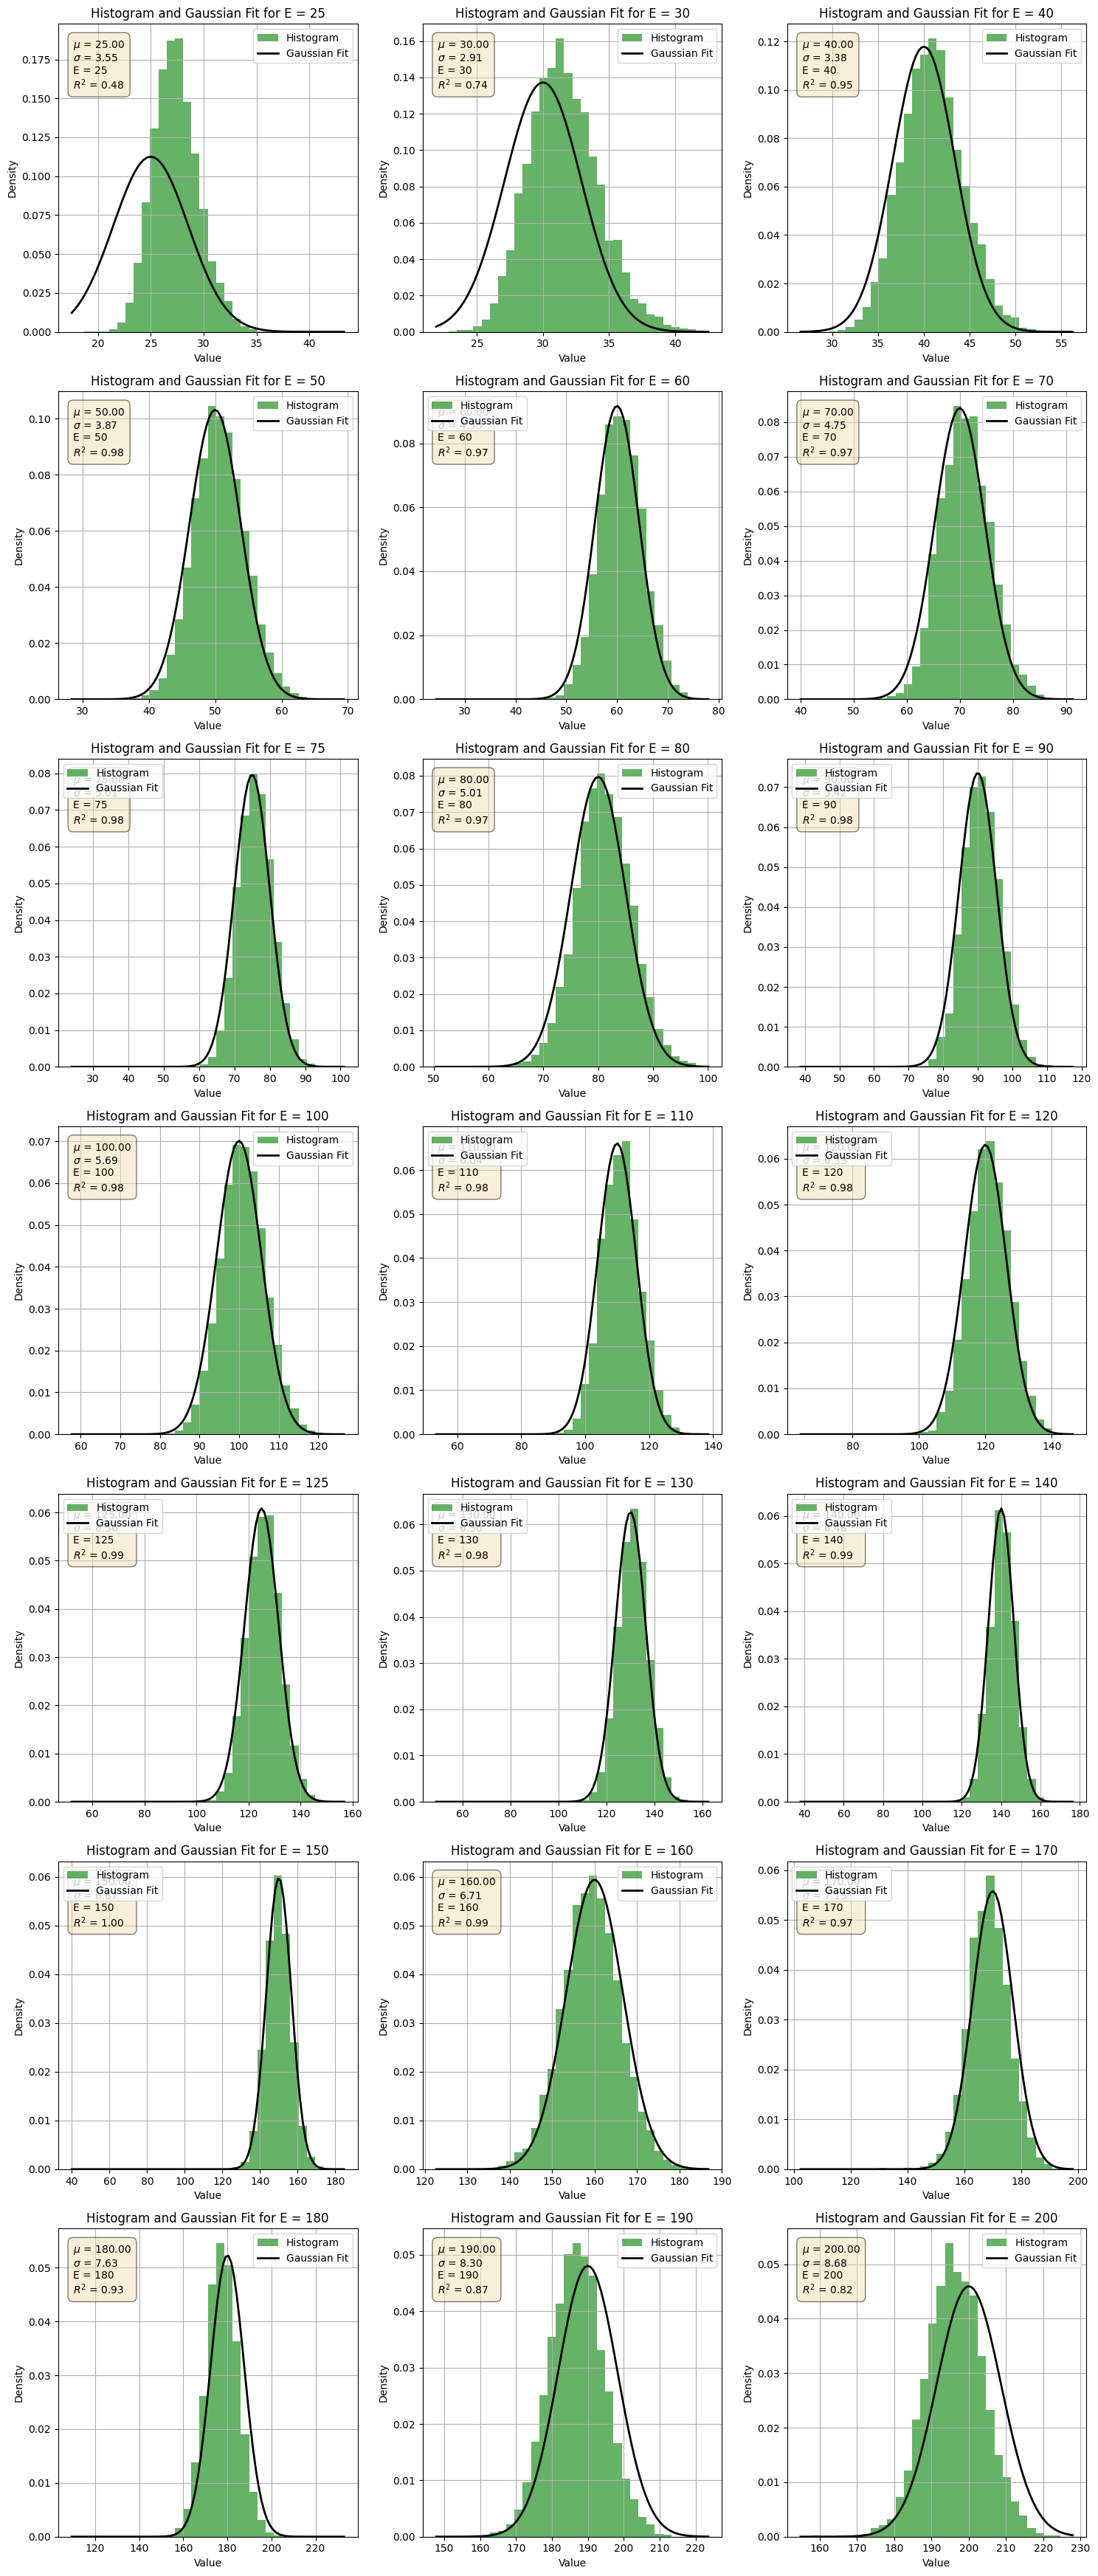

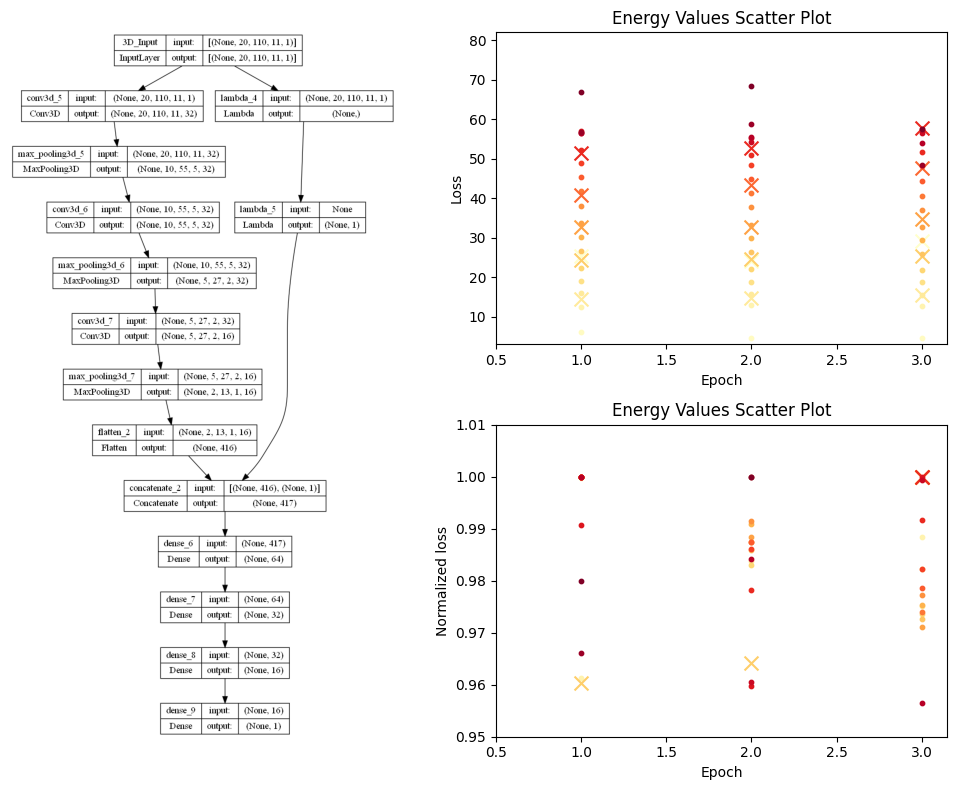

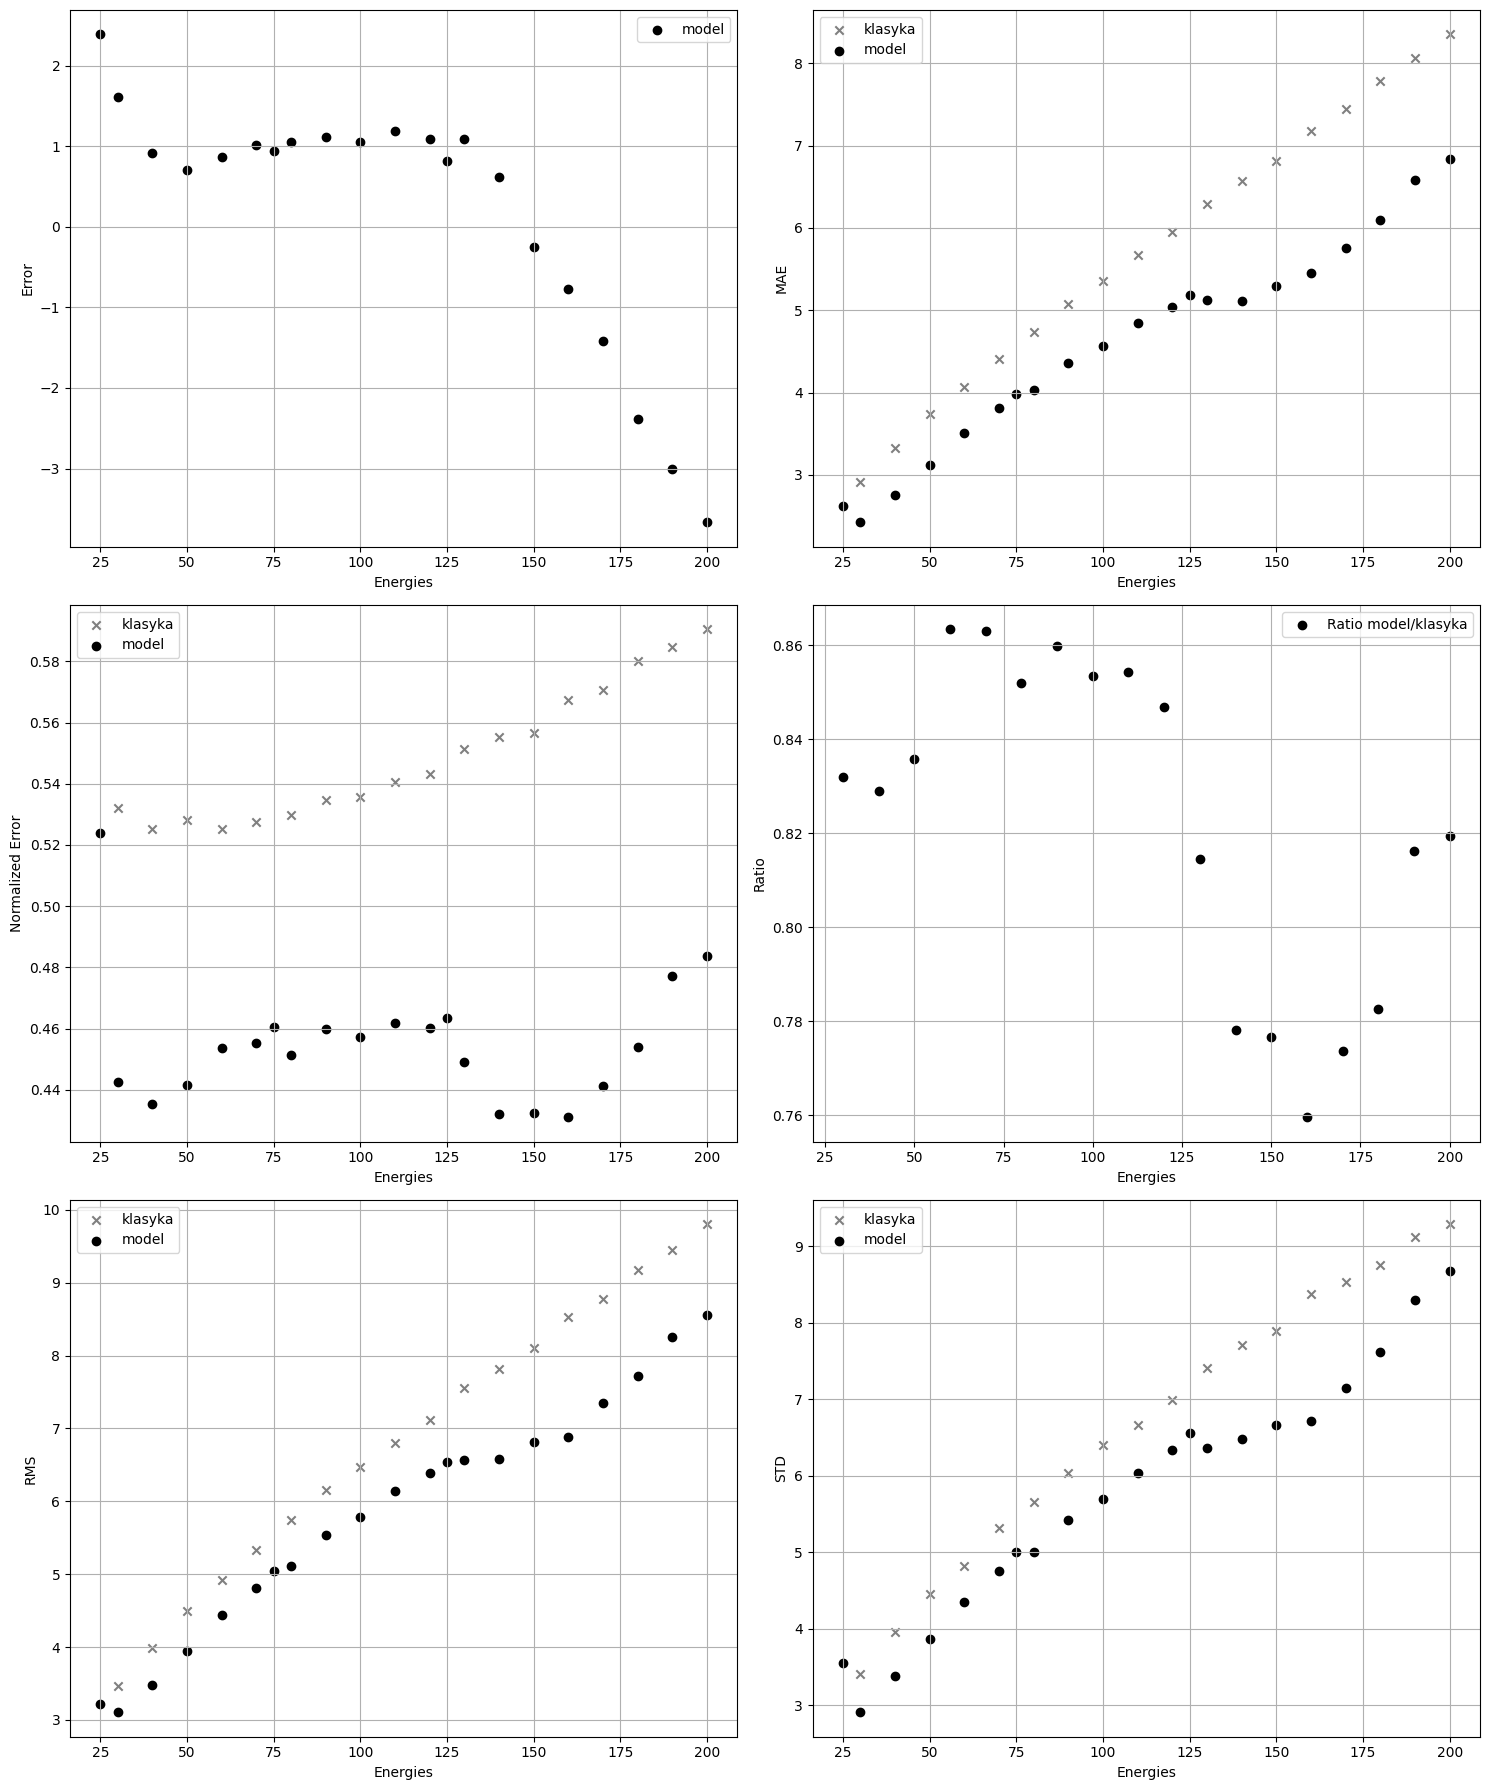

In [95]:
print("Inicjalizacja Grafiki")
RMS, ME, MAE, normMAE = Metrics(y_true, y_pred, Energies)
knormMAE=kMAE/np.sqrt(kTE)
STD=Gaussowisko(y_pred,y_true, np.unique(y_true), 30)
plot_training_data(Energies, 'training_log5.csv', 'model.png')
generate_subplots(np.unique(y_true), ME, kMAE, MAE, knormMAE, normMAE, kRMS, RMS, kSTD, STD, kTE)